# 将上面的模型优化，消除过拟合(acc:0.8)
## 用到的方法
- 在数据上使用数据增强技术：更多的数据
- 在模型上添加Dropout层：更好的模型
## 注意点
- 在数据增强生成数据时`batch_size*steps_per_epoch >= len(train_data)`，否则会导致训练的时候数据不够，训练提前结束
- 训练的次数要特别多，最后才能看到效果。我是放在kaggle上使用GPU训练，在后面才看到了效果，最后的精确率可以达到80%以上
- 训练的时候有比较明显的波动，但是最后结果还是比较令人满意，说明使用数据增强和Dropout能达到抑制过拟合的效果
- 这种大型的计算必须要放在云端去做了，自己本地的电脑是真的不行，速度基本没有在一个数量级，这是我在kaggle上的链接：[猫狗基线](https://www.kaggle.com/code/liuyixi/dogs_vs_cats_baseline)

In [1]:
# 直接用上面模型的那个数据集路径，这里只要把路径名声明一下即可
import os, shutil
original_dataset_dir = '../../data/cats_and_dogs/train'
base_dir = '../../data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_dir_dogs = os.path.join(train_dir, 'dogs')
valid_dir_dogs = os.path.join(valid_dir, 'dogs')
test_dir_dogs = os.path.join(test_dir, 'dogs')
train_dir_cats = os.path.join(train_dir, 'cats')
valid_dir_cats = os.path.join(valid_dir, 'cats')
test_dir_cats = os.path.join(test_dir, 'cats')

## 数据增强示例

In [2]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                                height_shift_range=0.2, shear_range=0.2,
                                zoom_range=0.2, horizontal_flip=True,
                                fill_mode='nearest')

2022-04-13 23:03:15.631304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 23:03:15.631349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


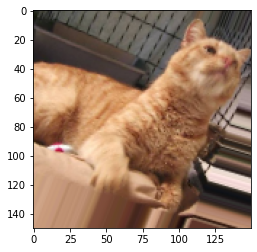

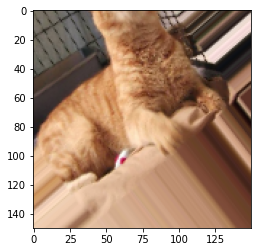

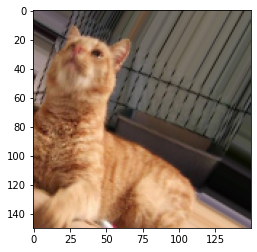

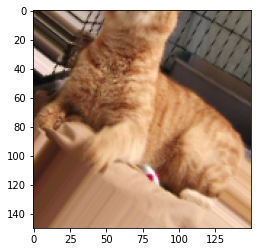

In [3]:
# 查看其中一个样本使用了数据增强后的图片
from keras.preprocessing import image
import matplotlib.pyplot as plt
fnames = [os.path.join(train_dir_cats, fname) for fname in os.listdir(train_dir_cats)[0:5]]
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [4]:
# 先优化模型，在将张量拉平后的全连接层上加入dropout
from keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
# 在全连接层上加入dropout
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 顺便编译模型
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

2022-04-13 23:03:33.797366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-13 23:03:33.797462: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 23:03:33.797502: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yy): /proc/driver/nvidia/version does not exist
2022-04-13 23:03:33.799080: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [5]:
# 生成训练数据集的数据增强器
# 注意：训练的数据集个数要大于batch_size*steps_per_epoch，否则会报错：数据不够用了，训练提前结束
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                    width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# train_datagen = ImageDataGenerator(rescale=1./255)
# 验证集，测试集都不用数据增强
test_datagen = ImageDataGenerator(rescale=1./255)            
# 获取增强后的训练集
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
        batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(valid_dir, target_size=(150, 150),
        batch_size=20, class_mode='binary')
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                                validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/tmp/ipykernel_20128/2439073770.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,


Epoch 1/100
 11/100 [==>...........................] - ETA: 3:07 - loss: 0.9821 - acc: 0.5182

KeyboardInterrupt: 

In [20]:
# 将训练好的模型保存下来
model.save('cats_and_dogs_small_2.h5')

In [ ]:
history.history

In [ ]:
# 绘制出来训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()